In [107]:
from lib.main_func_p1 import path, timer
import pandas as pd
from importlib import reload
from collections import OrderedDict
import lib.main_func_p4
from lib.main_func_p4 import modelXGBoost_fit_scores


#XGBoost library
import xgboost as xgb


In [108]:
# proteina (uniprot_ID)
uniprot_id = 'P56817'
excel_name = 'P56817_20220518005400_top_scores_XGBClassifier_f1_weighted'
path_file = path(uniprot_id)
# Parametros
seed = 142857
fp_name = 'morgan2_c'

In [109]:
# Load top_scores
top_scores = pd.read_excel(f'./top_scores/{excel_name}.xlsx')

# Best calibration scores
top_socres_len = 15
top_scores_top = top_scores.iloc[:top_socres_len]
top_scores_top_index_list = top_scores_top.index
top_scores

,model,params_dict,AUC_train,AUC_valid,accuracy_train,accuracy_valid,recall_train,recall_valid,specificity_train,specificity_valid,precision_train,precision_valid,f1_score_train,f1_score_valid,conf_matrix_train,conf_matrix_valid,calibration_score
0,modelID_1095,"OrderedDict([('alpha', 0.0), ('gamma', 0.2), (...",0.995,0.962,0.979,0.946,0.994,0.980,0.887,0.737,0.982,0.959,0.979,0.945,"[[605, 74], [27, 4141]]","[[89, 31], [15, 721]]",0.016104
1,modelID_1069,"OrderedDict([('alpha', 0.3), ('gamma', 0.0), (...",0.995,0.958,0.980,0.945,0.995,0.980,0.888,0.730,0.982,0.958,0.980,0.943,"[[604, 75], [21, 4147]]","[[88, 32], [15, 721]]",0.016114
2,modelID_981,"OrderedDict([('alpha', 0.0), ('gamma', 0.3), (...",0.994,0.961,0.980,0.938,0.994,0.980,0.894,0.680,0.982,0.950,0.979,0.935,"[[605, 74], [24, 4144]]","[[82, 38], [15, 721]]",0.016219
3,modelID_1033,"OrderedDict([('alpha', 0.5), ('gamma', 0.0), (...",0.994,0.964,0.979,0.944,0.994,0.981,0.887,0.717,0.982,0.955,0.979,0.942,"[[604, 75], [25, 4143]]","[[86, 34], [14, 722]]",0.016494
4,modelID_1032,"OrderedDict([('alpha', 1.0), ('gamma', 0.0), (...",0.994,0.963,0.979,0.943,0.995,0.980,0.881,0.716,0.981,0.955,0.979,0.941,"[[600, 79], [21, 4147]]","[[86, 34], [15, 721]]",0.016510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,modelID_6,"OrderedDict([('alpha', 2.0), ('gamma', 0.2), (...",0.916,0.906,0.891,0.875,1.000,0.999,0.222,0.114,0.888,0.874,0.860,0.831,"[[154, 525], [2, 4166]]","[[14, 106], [1, 735]]",0.080833
1096,modelID_3,"OrderedDict([('alpha', 0.7), ('gamma', 24.0), ...",0.930,0.914,0.892,0.880,0.999,0.999,0.235,0.150,0.889,0.878,0.862,0.840,"[[158, 521], [4, 4164]]","[[18, 102], [1, 735]]",0.080963
1097,modelID_5,"OrderedDict([('alpha', 2.0), ('gamma', 12.0), ...",0.937,0.924,0.893,0.879,1.000,1.000,0.236,0.137,0.889,0.876,0.863,0.836,"[[161, 518], [2, 4166]]","[[16, 104], [0, 736]]",0.081538
1098,modelID_2,"OrderedDict([('alpha', 0.2), ('gamma', 24.0), ...",0.919,0.912,0.882,0.871,1.000,1.000,0.158,0.080,0.879,0.870,0.843,0.822,"[[107, 572], [1, 4167]]","[[10, 110], [0, 736]]",0.091293


In [110]:
reload(lib.main_func_p4)
from lib.main_func_p4 import modelXGBoost_fit_scores
# Load train and validation datasets
df_train = pd.read_pickle(f'{path_file}_dataset_train')
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')

new_row_list = list()
results_ROF_list_train = list()
results_ROF_list_valid = list()
df_list = list()
plots_name_list = list()

for i, params_dict in enumerate(top_scores.params_dict.iloc[0:top_socres_len]):
    eval_metric = ['error', 'auc']
    tick = timer()
    params_dict_Orderer = params_dict
    params_dict = dict(eval(params_dict))
    default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective':'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds':10}
    params_dict.update(default_params_xgb)


    xgb_clf = xgb.XGBClassifier(**params_dict)

    # Train model and evaluating scores (train / validation)
    xgb_clf, scores_train, scores_valid = modelXGBoost_fit_scores(xgb_clf, fp_name, df_train, df_valid,
                                                                  resample_factor=4,
                                                                  resample_mode='under_sampling')

    if i == 0:
        xgb_clf.save_model(f'./models/{uniprot_id}_model.ubj')
        print(f'Best model saved ({top_scores.model.iloc[i]})')

    # ROF results
    results_ROF_list_train.append(scores_train[7])
    results_ROF_list_valid.append(scores_valid[7])

    # save pred and pred_prob of train set
    df = df_train[['activity', 'prediction', 'prediction_prob']].copy()
    df_list.append(df)

    plots_name_list.append(top_scores.model.iloc[i])
    print(f'{i+1}/{top_socres_len}. {top_scores.model.iloc[i]}. AUC_socre=(train={scores_train[0]},'
          f' valid={scores_valid[0]}). Time elapsed: {timer(tick)}')

under_sampling - 4: 4847 to 3395
Best model saved (modelID_1095)
1/15. modelID_1095. AUC_socre=(train=0.988, valid=0.98). Time elapsed: 3.3 seconds.
under_sampling - 4: 4847 to 3395
2/15. modelID_1069. AUC_socre=(train=0.987, valid=0.977). Time elapsed: 3.9 seconds.
under_sampling - 4: 4847 to 3395
3/15. modelID_981. AUC_socre=(train=0.988, valid=0.979). Time elapsed: 3.7 seconds.
under_sampling - 4: 4847 to 3395
4/15. modelID_1033. AUC_socre=(train=0.98, valid=0.972). Time elapsed: 3.2 seconds.
under_sampling - 4: 4847 to 3395
5/15. modelID_1032. AUC_socre=(train=0.984, valid=0.975). Time elapsed: 3.3 seconds.
under_sampling - 4: 4847 to 3395
6/15. modelID_1044. AUC_socre=(train=0.98, valid=0.975). Time elapsed: 3.1 seconds.
under_sampling - 4: 4847 to 3395
7/15. modelID_1031. AUC_socre=(train=0.981, valid=0.976). Time elapsed: 3.1 seconds.
under_sampling - 4: 4847 to 3395
8/15. modelID_732. AUC_socre=(train=0.985, valid=0.981). Time elapsed: 3.1 seconds.
under_sampling - 4: 4847 to 3

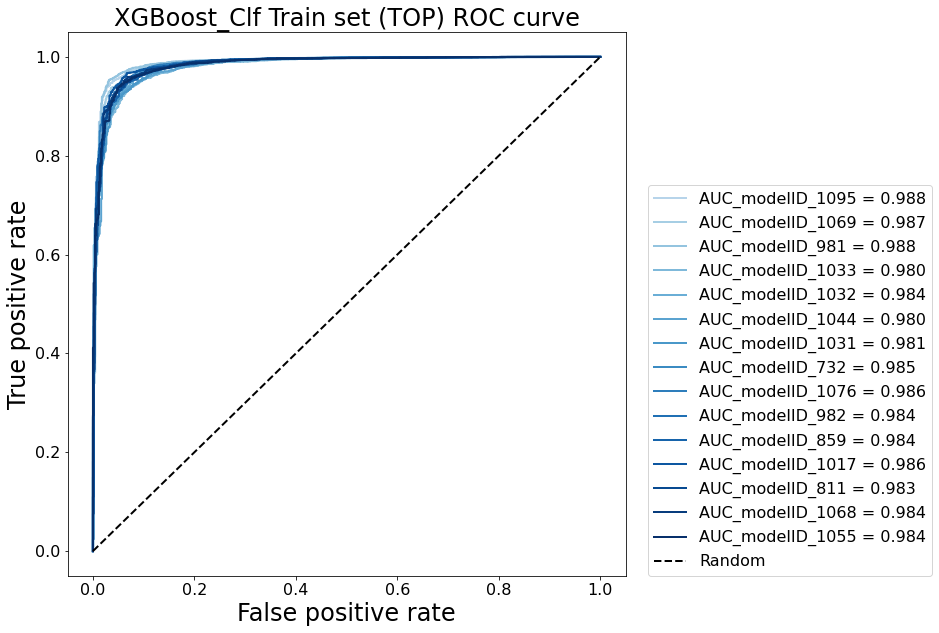

In [111]:
# ROC curve - best scores
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_ROC_curve
results_ROF_train_list_top = list()
results_ROF_valid_list_top = list()
ROC_plots_name_top_name = list()
for i in top_scores_top_index_list:
    results_ROF_train_list_top.append(results_ROF_list_train[i])
    results_ROF_valid_list_top.append(results_ROF_list_valid[i])
    ROC_plots_name_top_name.append(plots_name_list[i])

model_name = f'XGBoost_Clf Train set (TOP)'
plot_ROC_curve(results_ROF_train_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="train_Top_score", save_fig=True)

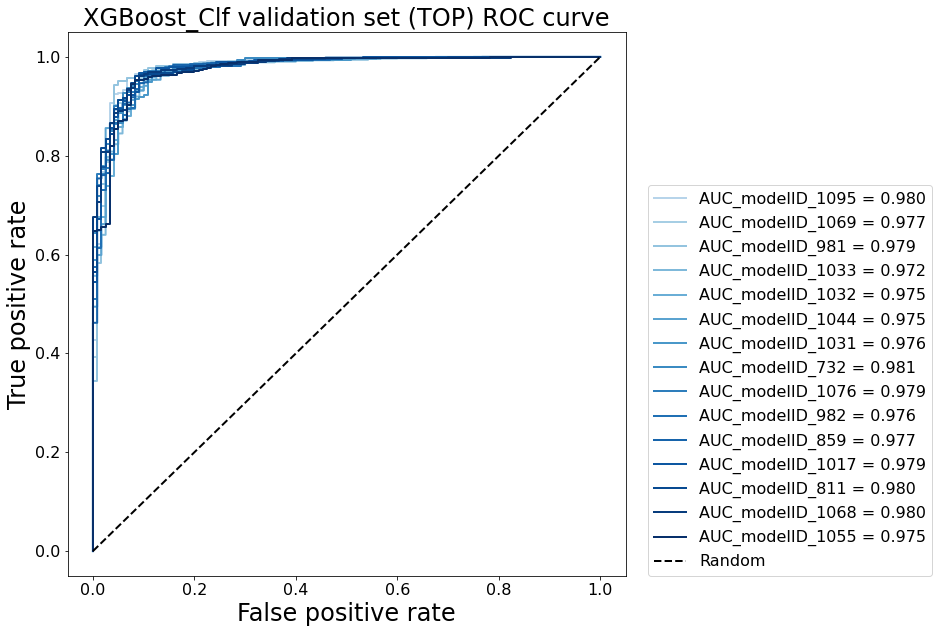

In [112]:
model_name = f'XGBoost_Clf validation set (TOP)'
plot_ROC_curve(results_ROF_valid_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="validation_Top_score", save_fig=True)

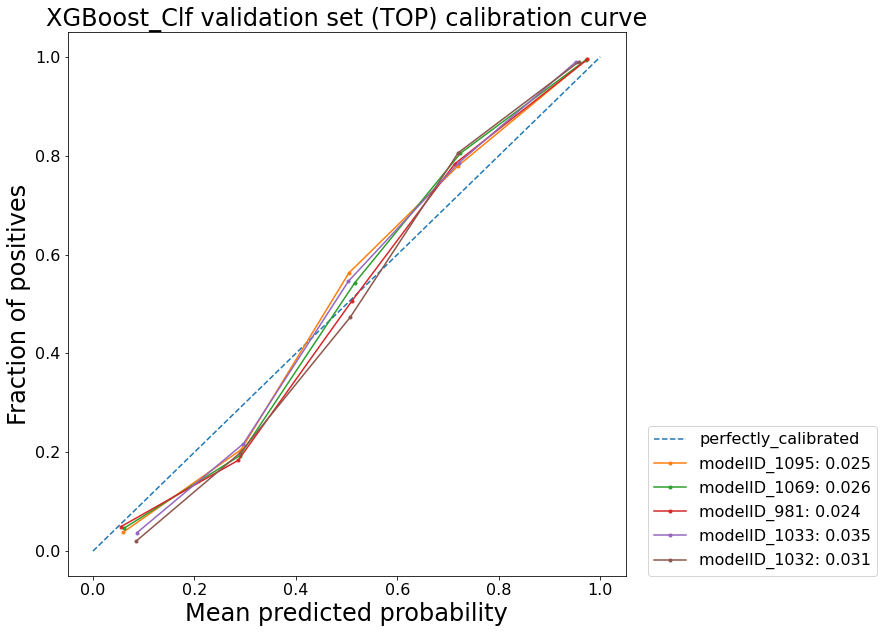

In [113]:
# Calibration curve - best scores (10)
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve
df_list_top = list()
df_list_top_name = list()

# Only graph top 5
for i in top_scores_top_index_list:
    df_list_top.append(df_list[i])
    df_list_top_name.append((plots_name_list[i]))
plot_calibration_curve(df_list_top[:5], df_list_top_name[:5], model_name,
                       path_file=path_file, name_mod="validation_Top_score", save_fig=True)